<a href="https://colab.research.google.com/github/samoliver3/capstone-STRIP-AI/blob/main/STRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mayo Clinic STRIP AI: Predicting Stroke Etiology from Whole Slide Digital Pathology Images
This notebook represents exploratory analysis and modeling for predicting ischemic stroke etiology.
* Student name: Sam Oliver
* Student pace: self-paced
* Scheduled project review: 
* Instructor name: Abhineet Kulkarni

# Overview of This Project
Stroke Thromboembolism Registery of Imaging and Pathology (STRIP) is a project run by the Mayo Clinic Neurovascular Lab across multiple centers with the following goal: histopathologic characterization of thromboemboli of various etiologies and examining clot composition and its relation to mechanical thrombectomy revascularization. This project will take advantage of resources collected by STRIP to predict stroke etiology (the origin of the stroke).
## Description of the problem
In the United States, over 700,000 people suffer an ischemic stroke every year, and stroke is the second most common cause of death in the world. Around 25% of people that have a stroke suffer one or more additional strokes. Identifying stroke etiology improves the likelihood of survival. 
## The dataset
The data from this project will come from the Mayo Clinic and is also part of a Kaggle competition. This dataset comprises more than one-thousand digital pathology images representing a blood clot that has manifested from a patient that has suffered an acute ischemic stroke (AIS).
## The stakeholder
The stakeholder is the Mayo Clinic, which is offering cash rewards to the creators of the top five best-scoring entries according to a scoring algorithm. The Mayo Clinic is asking for entries to classify images into one of the two major AIS categories for each image in a test set. These two major categories include Cardioembolic (CE) strokes and Large Artery Atherosclerosis (LAA) strokes.
## The evaluation algorithm
The evaluation algorithm is a weighted multi-class logarithmic loss that produces an effect of placing equal **importance on each category** for the final score.
The formula is as follows:

![eval_formula](https://drive.google.com/uc?export=view&id=19qGOpvOoahqduMBI28ywYLnG1EiLDfyg)


Definitions of elements in the formula:
* M - number of classes
* N - number of images in the class set
* y_ij - equal to 1 if observation i belongs to class j and 0 otherwise
* p_ij - predicted probability that image i belongs to class j.
* w_i - the weight of each class. w1 = w2 = 0.5 because both classes are weighted equally.

# Exploratory Data Analysis (EDA)
## Import packages and data

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from google.colab import drive
from pathlib import Path

from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import datetime

from tensorflow.random import set_seed
set_seed(13)

In [ ]:
# define paths for the data
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images'
test_path = '/content/drive/MyDrive/Flatiron/Capstone/test'

In [ ]:
# load csv files in
train_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/test.csv')

train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


There are several different centers that have contributed images to this dataset. I'm not sure what the image_num column is supposed to keep track of.

In [ ]:
test_df.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


The test dataset does not have a label column because of the nature of the Kaggle competition. It is concealed so that predictions are made on the test set and scored with the evaluation algorithm on the Kaggle competition.

## Preview metadata

First, look for null-data and inspect type of data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes


No null data in either set.
Now, look into distribution of images in respect to the target in the train dataset.

In [ ]:
train_df.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In the train dataset, there are 547 Cardiacembolic images and 207 Large Artery Atherosclerosis images.
Let's visualize this distribution below.

Text(0.5, 1.0, 'Distribution of Stroke Etiology in the Train Dataset')

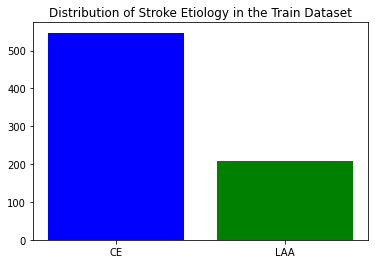

In [ ]:
# visualize distribution
plt.bar(['CE', 'LAA'], [547, 207], color=['b', 'g'])
plt.title('Distribution of Stroke Etiology in the Train Dataset')

The distribution is almost 2:1 in favor of CE.

Now, visualize the number of images of clots obtained from the same patient (image_num) column and the distribution of how many images are taken at each center. I'm adapting some visualization efforts used by Robert Kwiatkowski in this competition in his first section, "Images metadata", which can be found [here](https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration). 

In [ ]:
# group data together for both categories and plot with Seaborn

# group data
p_no = train_df.groupby('image_num')['image_num'].count().div(len(train_df)).mul(100)
c_no = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

# plot
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=p_no.index, y=p_no.values, ax=ax[0])
ax[0].set_title("No. images obtained from the same patient"), ax[0].set_ylabel("%")
sns.barplot(x=c_no.index, y=c_no.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

Clinic 11 represents around 35% of the total images. Centers 8 & 9 have a low concentration of images in the dataset with only about 2% each.

## Preview some images

Let's take a look at some of the images in the train set.

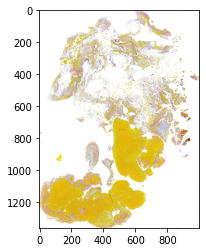

In [20]:
from PIL import Image
images = []

# png file type in train folder
for filename in glob.glob('/content/drive/MyDrive/Flatiron/Capstone/train_images/*.png'):
    im=Image.open(filename)
    images.append(im)

plt.imshow(images[0])

Here's the first image. Let's check out the metadata of the images list for a quick sanity check, and also check out some more of the images.

In [21]:
# check out data types for the image list and individual images
i_l_t = type(images)     # type for images list
i_t = type(images[4])     # type for an image in the image list

# look at size of the list- should be 754. I know it will be 752- I'll fix later
i_l_s = len(images)

# print out meta findings
print(f"Type of image list: {i_l_t}")
print(f"Type of image in the list: {i_t}")
print(f"Number of images in the set: {i_l_s}")

Type of image list: <class 'list'>
Type of image in the list: <class 'PIL.PngImagePlugin.PngImageFile'>
Number of images in the set: 752


Images are png type, but there are only 752 of them, even though there are 754 in the original dataset. This discrepancy is because I am using a modified dataset from the original Kaggle competition. I am using a dataset from Jirka Borovec who converted the original iamges with .tif type and reduced the size of the images through a technique to reduce empty background space. These images are .png type and they compose the folder found in my train_path. The link to the dataset is [here](https://www.kaggle.com/datasets/jirkaborovec/stroke-blood-clot-origin-1k-scale-bg-crop).

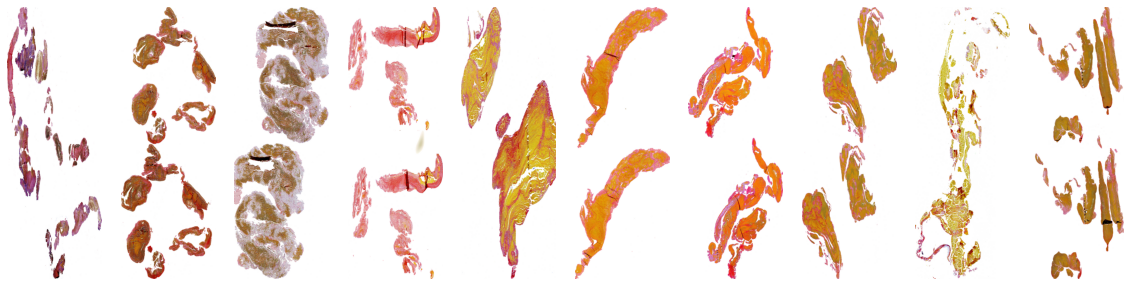

In [28]:
# Look at some more images in the train set:

# Generate list of 10 different random numbers from 0-751
import random
r_l = random.sample(range(0, 751), 10)     # sample with replacement

fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
  ax[i].imshow(images[r_l[i]])     # show image at the random index
  ax[i].axis('off')
  ax[i].set_aspect('auto')

plt.show()

It seems like a lot of these images are mirrored. But I think what's occurring here is that the cross-sectional area of each clot is scanned on both sides; or it might be the case that each individual fragment is cut, and multiple cross-sectional areas of the same clot are scanned.

## Clean the dataset
Steps to take:
1. There are several images that should be removed from the dataset because they are very smooth. The resolution of these images are very low and may reduce success of any future prediction algorithm created in this project. The IDs of these images are found from a Kaggle discussion on this project [here](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/discussion/338256), and they include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
2. There are two images that are described in the train metadata but not in the train images. I am going to find the IDs of these two missing images and remove them from the train csv (metadata) because I will have to associate each image with labels from the train csv file, and the presence of additional labels may interfere with that process as well as other, further exploration of train metadata.

In [33]:
# I want to create a list or df column of string type data that contains all the 
# names (IDs) of each individual image.
t_img_ids = os.listdir(train_path)
print(len(t_img_ids))
print(t_img_ids[5])

752
098f15_0.png


Recall the '.png' ending for each of these images. Remove these endings for ease later when I find the missing entries.

In [38]:
# loop through images in t_img_ids and remove .png ending
train_img_ids = []     # new list to append altered objects

for i_id in t_img_ids:
  new_id = i_id[:-4]
  # train_img_ids.append(i_id.removesuffix('.png'))
  train_img_ids.append(new_id)

# preview one of the altered list items for a quick sanity check
train_img_ids[82]

'24f8f5_0'

In [42]:
# get list of image ids in the train csv file
train_df_ids = train_df.image_id.to_list()

# get the missing elements through set subtraction
missing_imgs = list(set(train_df_ids) - set(train_img_ids))
missing_imgs

['b894f4_0', '6baf51_0']

So, the images to clean out of the train_csv file include: b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.
The images to remove from the train image dataset include: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0.

In [50]:
# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# length should be 748
len(train_df)

748

In [51]:
# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

# check the modified dataframe
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


Looks good. Now, move on to clean the image folder. To reiterate from above, remove images with these IDs: 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0. I will be copying the image dataset in my Google Drive, removing these images, and then calling this new file path for train_path.

In [60]:
# redefine train_path
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images_cleaned'

# check if the images were actually removed - length should be 748
len(os.listdir(train_path))

748